In [58]:
import arff
import pandas as pd
import numpy as np
import re
import requests
import tldextract
from urllib.parse import urlparse
from bs4 import BeautifulSoup
import whois
from datetime import datetime
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    RocCurveDisplay,
)
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns



In [59]:
with open('phishing+websites/Training Dataset.arff', 'r') as f:
    arff_data = arff.load(f)
df = pd.DataFrame(arff_data['data'], columns=[attr[0] for attr in arff_data['attributes']])

# Clean and prepare
df = df.replace('?', np.nan).fillna(0)
for col in df.columns:
    if col != 'Result':
        df[col] = pd.to_numeric(df[col], errors='coerce')
df['Result'] = pd.to_numeric(df['Result'], errors='coerce').replace(-1, 0)
df = df[df['Result'].isin([0, 1])]

X = df.drop(columns=['Result'])
y = df['Result']
feature_columns = X.columns.tolist()


C:\Users\zalha\AppData\Local\Temp\ipykernel_10232\186460241.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="pastel")


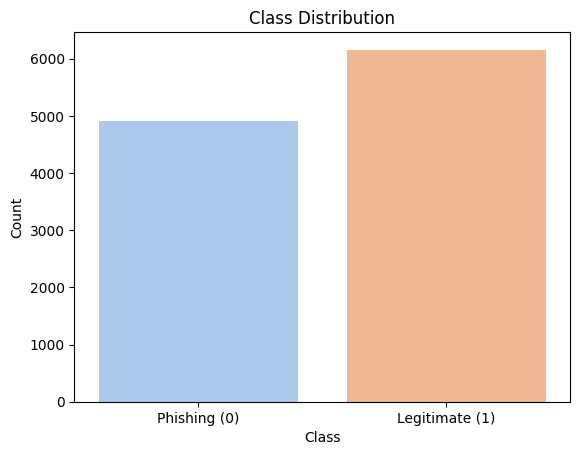

In [72]:
# Plot class distribution
plt.figure()
sns.countplot(x=y, palette="pastel")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(ticks=[0, 1], labels=["Phishing (0)", "Legitimate (1)"])
plt.show()

In [60]:
def get_whois_info(domain):
    try:
        print(f"Querying WHOIS for domain: {domain}")
        w = whois.whois(domain)
        creation = w.creation_date
        expiration = w.expiration_date
        if isinstance(creation, list): creation = creation[0]
        if isinstance(expiration, list): expiration = expiration[0]
        now = datetime.now()
        age = (now - creation).days if creation else 0
        reg_length = (expiration - creation).days if creation and expiration else 0
        return age, reg_length
    except Exception as e:
        print(f"WHOIS query failed for domain {domain}: {e}")
        return 0, 0


In [61]:
def extract_arff_features(url, expected_columns):
    features = {}
    def has_ip(url): return 1 if re.match(r"^(http[s]?://)?\d+\.\d+\.\d+\.\d+", url) else 0
    def shortening_service(url): return 1 if re.search(r"(bit\.ly|goo\.gl|tinyurl|ow\.ly|t\.co|x\.co)", url) else 0
    def has_at_symbol(url): return 1 if '@' in url else 0
    def double_slash_redirect(url): return 1 if url.rfind('//') > 6 else 0
    def prefix_suffix(domain): return 1 if '-' in domain else 0
    def sub_domain_count(url):
        hostname = urlparse(url).hostname or ''
        return 2 if hostname.count('.') > 2 else (1 if hostname.count('.') == 2 else 0)
    def ssl_state(url): return 1 if url.startswith("https") else 0
    def favicon_check(domain, soup):
        icons = soup.find_all("link", rel=lambda x: x and 'icon' in x.lower())
        for icon in icons:
            href = icon.get("href", "")
            if domain not in href: return 1
        return 0

    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, timeout=10)
        html = response.text
        soup = BeautifulSoup(html, 'html.parser')
    except:
        html = ""
        soup = BeautifulSoup("", 'html.parser')

    parsed = urlparse(url)
    ext = tldextract.extract(url)
    domain = parsed.netloc
    full_domain = ext.domain + "." + ext.suffix

    age, reg_length = get_whois_info(full_domain)

    features['having_IP_Address'] = has_ip(url)
    features['URL_Length'] = len(url)
    features['Shortining_Service'] = shortening_service(url)
    features['having_At_Symbol'] = has_at_symbol(url)
    features['double_slash_redirecting'] = double_slash_redirect(url)
    features['Prefix_Suffix'] = prefix_suffix(full_domain)
    features['having_Sub_Domain'] = sub_domain_count(url)
    features['SSLfinal_State'] = ssl_state(url)
    features['Domain_registeration_length'] = reg_length
    features['Favicon'] = favicon_check(domain, soup)
    features['port'] = 0
    features['HTTPS_token'] = 1 if 'https' in domain.lower() else 0

    imgs = soup.find_all('img', src=True)
    total_imgs = len(imgs)
    external_imgs = len([img for img in imgs if ext.domain not in img['src']])
    features['Request_URL'] = 1 if total_imgs > 0 and external_imgs / total_imgs >= 0.5 else 0

    anchors = soup.find_all('a', href=True)
    total_anchors = len(anchors)
    null_anchors = len([a for a in anchors if a['href'] in ['#', 'javascript:void(0);', ''] or ext.domain not in a['href']])
    features['URL_of_Anchor'] = 1 if total_anchors > 0 and null_anchors / total_anchors > 0.5 else 0

    tags = soup.find_all(['link', 'script', 'meta'], href=True)
    external_tags = len([tag for tag in tags if ext.domain not in tag.get('href', '')])
    features['Links_in_tags'] = 1 if external_tags > 2 else 0

    forms = soup.find_all('form', action=True)
    suspicious_forms = len([form for form in forms if form['action'] == "" or ext.domain not in form['action']])
    features['SFH'] = 1 if len(forms) > 0 and suspicious_forms / len(forms) >= 0.5 else 0

    features['Submitting_to_email'] = 1 if re.search(r"mailto:", html.lower()) else 0
    features['Abnormal_URL'] = 1 if domain not in url else 0
    features['Redirect'] = 1 if soup.find('meta', attrs={'http-equiv': re.compile("refresh", re.I)}) or re.search(r"window\.location|location\.replace", html.lower()) else 0
    features['on_mouseover'] = 1 if re.search(r"onmouseover\s*=", html.lower()) else 0
    features['RightClick'] = 1 if re.search(r"event.button\s*==\s*2", html.lower()) else 0
    features['popUpWidnow'] = 1 if re.search(r"alert\s*\(", html.lower()) else 0
    features['Iframe'] = 1 if "<iframe" in html.lower() else 0

    features['age_of_domain'] = age
    features['DNSRecord'] = 1
    features['web_traffic'] = 0
    features['Page_Rank'] = 0
    features['Google_Index'] = 1 if "google" in html.lower() else 0
    features['Links_pointing_to_page'] = len(anchors)
    features['Statistical_report'] = 0

    for col in expected_columns:
        if col not in features:
            features[col] = 0

    return pd.DataFrame([[features[col] for col in expected_columns]], columns=expected_columns)


In [62]:
# 🐟 Updated list of known phishing URLs
phish_urls = [
    "http://toncoinsp.com",
    "http://www.paypa1.com",
    "http://www.faceb00k-login.com",
    "http://www.apple-support-security-alert.com",
    "http://www.bankofamerica-login.com",
    "http://www.g00gle-login-attempt.com",
    "http://paypal-opladen.be",
    "http://login.microsoftonline.ccisystems.us",
    "http://login-amazon-account.com",
    "http://apple-grx-support-online.com",
    "http://renew-netflix.com",
    "http://allegrolokalnie.pl-1751.cfd",
    "http://mondiai-rps.com/index.php"
]

# Extract features and label them as phishing (Result = 0)
new_phish_samples = []
for url in phish_urls:
    try:
        feat = extract_arff_features(url, feature_columns)
        feat["Result"] = 0
        new_phish_samples.append(feat)
    except Exception as e:
        print(f"❌ Failed to process {url}: {e}")

# Add new phishing samples to the existing dataset
if new_phish_samples:
    df_phish = pd.concat(new_phish_samples, ignore_index=True)
    df = pd.concat([df, df_phish], ignore_index=True)

# ✅ Rebuild feature and label sets
X = df.drop(columns=['Result'])
y = df['Result']


Querying WHOIS for domain: toncoinsp.com
Querying WHOIS for domain: paypa1.com
Querying WHOIS for domain: faceb00k-login.com
WHOIS query failed for domain faceb00k-login.com: No match for "FACEB00K-LOGIN.COM".
>>> Last update of whois database: 2025-05-14T05:08:20Z <<<

NOTICE: The expiration date displayed in this record is the date the
registrar's sponsorship of the domain name registration in the registry is
currently set to expire. This date does not necessarily reflect the expiration
date of the domain name registrant's agreement with the sponsoring
registrar.  Users may consult the sponsoring registrar's Whois database to
view the registrar's reported date of expiration for this registration.

TERMS OF USE: You are not authorized to access or query our Whois
database through the use of electronic processes that are high-volume and
automated except as reasonably necessary to register domain names or
modify existing registrations; the Data in VeriSign Global Registry
Services' ("Ve

In [63]:
# 🔁 Retrain the XGBoost model with updated data
model = lgb.LGBMClassifier()


In [64]:
# Split your dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Retrain on training split (optional but recommended for realistic evaluation)
model.fit(X_train, y_train)

# Predict on test split
y_pred = model.predict(X_test)

# Evaluate
print("📈 Model Evaluation Metrics:\n")
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n🧮 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred, target_names=["Phishing (0)", "Legitimate (1)"]))


[LightGBM] [Info] Number of positive: 4925, number of negative: 3929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 100
[LightGBM] [Info] Number of data points in the train set: 8854, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556246 -> initscore=0.225939
[LightGBM] [Info] Start training from score 0.225939
📈 Model Evaluation Metrics:

✅ Accuracy: 0.964769647696477

🧮 Confusion Matrix:
 [[ 937   45]
 [  33 1199]]

📋 Classification Report:
                 precision    recall  f1-score   support

  Phishing (0)       0.97      0.95      0.96       982
Legitimate (1)       0.96      0.97      0.97      1232

      accuracy                           0.96      2214
     macro avg       0.96      0.96      0.96      2214
  weighted avg       0.96      

In [65]:
test_url = input("🔍 Enter a URL to check: ").strip()

def is_valid_url(url):
    parsed = urlparse(url)
    return bool(parsed.scheme) and bool(parsed.netloc)

if is_valid_url(test_url):
    try:
        features_df = extract_arff_features(test_url, feature_columns)
        print("\n✅ Extracted Features:")
        print(features_df.T)

        proba = model.predict_proba(features_df)[0][1]
        print(f"\n🎯 Phishing Probability: {proba:.4f}")

        if proba > 0.85:
            print("✅ Legitimate (High confidence)")
        elif proba > 0.5:
            print("⚠️ Suspicious – Further analysis recommended")
        else:
            print("❌ Phishing (High confidence)")

    except Exception as e:
        print("❌ Error processing URL:", e)
else:
    print("⚠ Invalid URL format. Please include http:// or https://")


Querying WHOIS for domain: reigokaitranslations.com

✅ Extracted Features:
                               0
having_IP_Address              0
URL_Length                    84
Shortining_Service             0
having_At_Symbol               0
double_slash_redirecting       0
Prefix_Suffix                  0
having_Sub_Domain              0
SSLfinal_State                 1
Domain_registeration_length  365
Favicon                        0
port                           0
HTTPS_token                    0
Request_URL                    1
URL_of_Anchor                  0
Links_in_tags                  1
SFH                            1
Submitting_to_email            0
Abnormal_URL                   0
Redirect                       1
on_mouseover                   0
RightClick                     0
popUpWidnow                    0
Iframe                         1
age_of_domain                235
DNSRecord                      1
web_traffic                    0
Page_Rank                      0
G

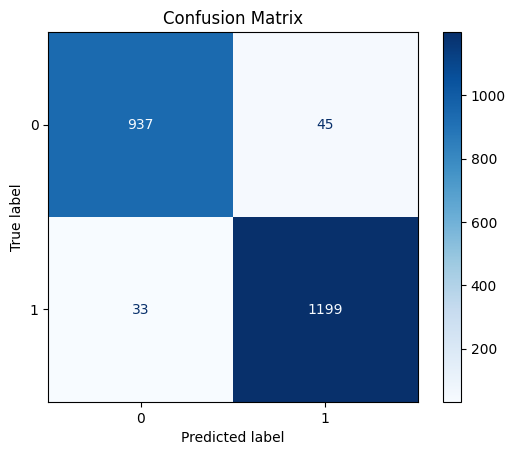

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       982
           1       0.96      0.97      0.97      1232

    accuracy                           0.96      2214
   macro avg       0.96      0.96      0.96      2214
weighted avg       0.96      0.96      0.96      2214



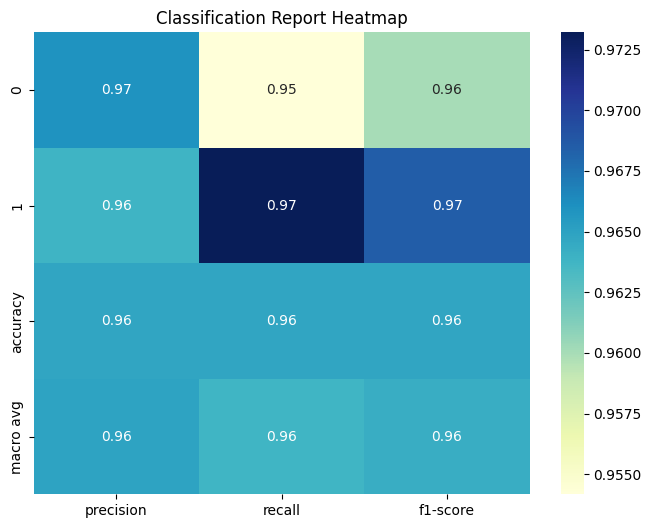

In [67]:
print(classification_report(y_test, y_pred))

report = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(df.iloc[:-1, :-1], annot=True, cmap="YlGnBu")
plt.title("Classification Report Heatmap")
plt.show()

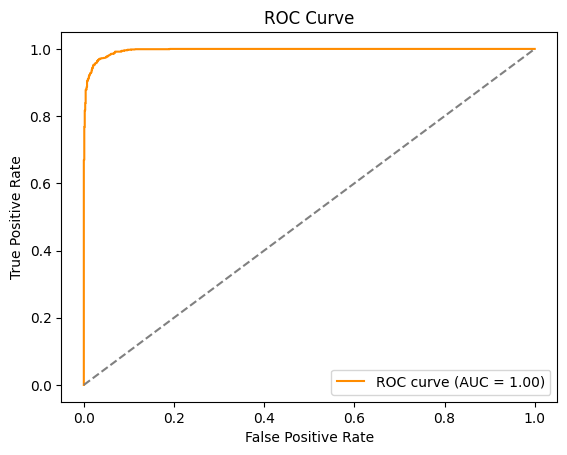

In [68]:
# For binary classification
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


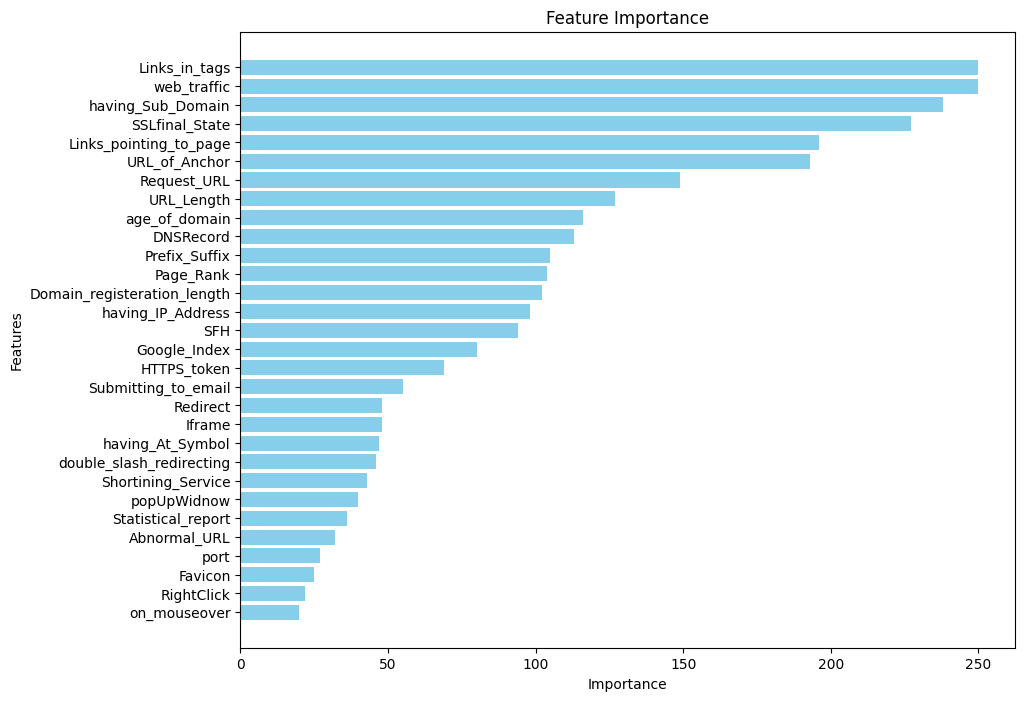

In [69]:
feature_importances = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

[LightGBM] [Info] Number of positive: 501, number of negative: 384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 885, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.566102 -> initscore=0.265964
[LightGBM] [Info] Start training from score 0.265964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

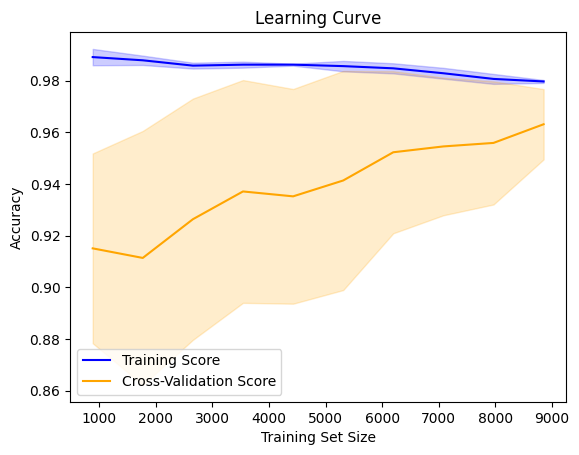

In [70]:
# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(train_sizes, test_mean, label="Cross-Validation Score", color="orange")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="orange", alpha=0.2)
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()